# Machine Learning Project Checklist

1. **Frame the problem and look at the big picture.**

2. **Get the data.**

3. Explore the data to gain insights.

4. Explore many different models and short-list the best ones.

5. Fine-tune your models and combine them into a great solution.

6. Present your solution.

## 1. Frame the problem and look at the big picture

### Objective

Build an **intuitive** Machine Learning model to evaluate fair price of the given property in Budapest
- Dependent variable (predicted): **Price per squaremeter**
- Explanatory variables (features): GPS coordinates (**Latitude**, **Longitude**)

## 2. Get the data
- Python script
- Turn website into data
- Scraping data from [website](https://realestate.hu/ "Real Estate's Homepage")

## 3. Explore the data to gain insigths
- Study each attribute and its characteristics
- Visualize the data
- Study the correlations between attributes

In [1]:
import translation
import pickle
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import normaltest
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
from utils import *
%matplotlib inline

In [2]:
DATA_DIR='./data'
INPUT_DIR='../real_estate_hungary/output'
FILENAME='ForSaleRent_20181101.csv'
INPUT_FILEPATH=os.path.join(INPUT_DIR, FILENAME)
IMG_DIR='./img'

In [3]:
na_hun_equivalent='nincs megadva'

### Load scraped data

In [4]:
raw=pd.read_csv(INPUT_FILEPATH, encoding='utf8', na_values=na_hun_equivalent)

### Translation from Hungarian to English

In [5]:
raw=translation.transform_naming(raw)

### Data structure/columns
Three categories:
1. Unique ID
2. Possible features
3. Technical columns

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55146 entries, 0 to 55145
Data columns (total 60 columns):
address                     55120 non-null object
accessibility               14456 non-null object
batch_num                   55146 non-null int64
ceiling_height              37722 non-null object
buses                       36823 non-null object
buses_count                 36823 non-null float64
furnished                   8593 non-null object
cluster_id                  55146 non-null object
property_id                 55146 non-null int64
desc                        54531 non-null object
city_district               55146 non-null int64
smoking                     4822 non-null object
floors                      50258 non-null object
energy_perf_cert            2809 non-null object
balcony                     23573 non-null object
bath_and_wc                 29760 non-null object
type_of_heating             49418 non-null object
equipped                    7926 non-null obje

In [7]:
composite_id=['property_id', 'timestamp']

In [8]:
technical=['property_url', 'cluster_id', 'batch_num', 'page_num', 'max_page', 'max_listing', 'is_ad_active']

In [9]:
possible_features=raw.columns[~raw.columns.isin(technical)&~raw.columns.isin(composite_id)].tolist()

### Drop duplicated records

In [10]:
unique_records=raw[[composite_id[0]]+possible_features].drop_duplicates()
unique_records_idx=unique_records.index
total_records=len(raw)
unique_total_ratio=len(unique_records)/total_records
print('Total number of records: {0:,}'.format(total_records))
print('Unique record ratio is {0:%}'.format(unique_total_ratio))

Total number of records: 55,146
Unique record ratio is 97.325282%


In [11]:
u_raw=raw.loc[unique_records_idx, possible_features + composite_id]

### Adding unique id column
- Composed from **property_id** and **timestamp**

In [12]:
ts_fmt='%Y-%m-%d %H:%M:%S.%f'
u_raw['id']=u_raw['property_id']+u_raw['timestamp'].apply(lambda ts: datetime.datetime.strptime(ts, ts_fmt).timestamp())

In [13]:
u_raw.loc[:,possible_features].head()

address accessibility       ceiling_height        buses  \
0  Budai Bolero II          igen                  NaN  103|133E|33   
1   Csata utca 30.           NaN  3 m-nél alacsonyabb    14|32|105   
2   Csata utca 30.           NaN  3 m-nél alacsonyabb    14|32|105   
3   Csata utca 30.           NaN  3 m-nél alacsonyabb    14|32|105   
4   Csata utca 30.           NaN  3 m-nél alacsonyabb    14|32|105   

   buses_count furnished                                               desc  \
0          3.0       NaN  | Exkluzív otthon az Ön igényeire szabva! A Bu...   
1          3.0       NaN  | XIII  kerület közkedvelt részén  az Árpád-hí...   
2          3.0       NaN  | XIII  kerület közkedvelt részén  az Árpád-hí...   
3          3.0       NaN  | XIII  kerület közkedvelt részén  az Árpád-hí...   
4          3.0       NaN  | XIII  kerület közkedvelt részén  az Árpád-hí...   

   city_district smoking     floors       ...       trolley_buses  \
0             11     NaN         10       ...                 NaN   
1             13     NaN  földszint       ...                 NaN   
2             13     NaN          2       ...                 NaN   
3             13     NaN          1       ...                 NaN   
4             13     NaN          5       ...                 NaN   

  trolley_buses_count listing_type  orientation trams trams_count  \
0                 NaN     for-sale       nyugat     1         1.0   
1                 NaN     for-sale  északnyugat  1|14         2.0   
2                 NaN     for-sale    délnyugat  1|14         2.0   
3                 NaN     for-sale  északnyugat  1|14         2.0   
4                 NaN     for-sale   északkelet  1|14         2.0   

   all_night_services all_night_services_count  year_built building_floors  
0                 NaN                      NaN        2019              10  
1            914|914A                      2.0         NaN               5  
2            914|914A                      2.0        2018               5  
3            914|914A                      2.0        2018               5  
4            914|914A                      2.0        2018               5  

[5 rows x 51 columns]

### Available listing types
- for-sale
- for-rent

In [14]:
sale_flt=u_raw.listing_type=='for-sale'
rent_flt=u_raw.listing_type=='for-rent'

### Missing values

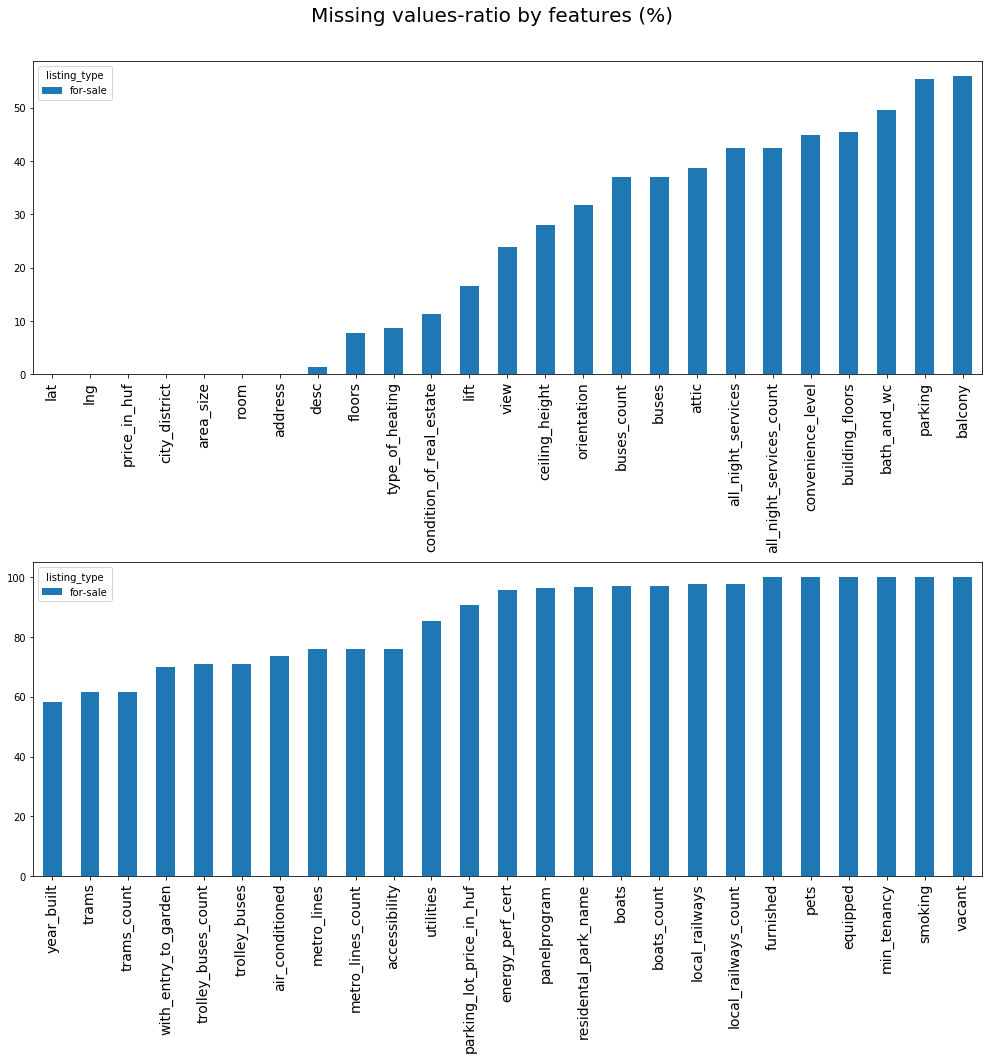

In [15]:
plot_na_ratio(u_raw.loc[sale_flt, possible_features], grouping='listing_type', dest_dir=IMG_DIR)

### Handling missing values
1. No action, using only fully represented variables
2. Impute with mean, median, mode
3. Model different features leveraging of other variables
4. Using *Natural Language Processing* on property description and combine with the 3rd option 

- Fully represented variables:

In [16]:
fully_repr=['id', 'lng', 'lat', 'price_in_huf', 'area_size', 'room', 'city_district', 'address', 'listing_type'] + ['residental_park_name',]

In [17]:
listings=u_raw.loc[:, fully_repr].copy()

In [18]:
listings.dtypes

id                      float64
lng                     float64
lat                     float64
price_in_huf             object
area_size                object
room                     object
city_district             int64
address                  object
listing_type             object
residental_park_name     object
dtype: object

In [19]:
listings.head()

id        lng        lat    price_in_huf area_size         room  \
0  1.567544e+09  19.048690  47.460680  69.9 millió Ft     92 m²   3 + 1 fél    
1  1.565945e+09  19.079060  47.529858  50.3 millió Ft     75 m²           3    
2  1.566792e+09  19.078869  47.529730  49.5 millió Ft     75 m²           3    
3  1.568972e+09  19.079060  47.529858  46.1 millió Ft     71 m²           3    
4  1.568226e+09  19.079060  47.529858  62.9 millió Ft     77 m²           3    

   city_district          address listing_type residental_park_name  
0             11  Budai Bolero II     for-sale      Budai Bolero II  
1             13   Csata utca 30.     for-sale                  NaN  
2             13   Csata utca 30.     for-sale                  NaN  
3             13   Csata utca 30.     for-sale                  NaN  
4             13   Csata utca 30.     for-sale                  NaN

### Convert strings to numeric
- Price - three categories:
    1. Billion (milliárd)
    2. Million (millió)
    3. Hungarian Forint (Ft)<br><br>
- Area size:
    - Remove m$^2$ (square meter)<br><br>
- Price per squaremeter:
    $\frac{price}{area}$<br><br>
- Number of rooms - splitting into two category
    1. Number of full rooms (room >12 m$^2$)
    2. Number of half rooms (room <12 m$^2$)
    3. Adding total number of rooms

In [20]:
listings['price_in_huf']=raw.price_in_huf.apply(extract_num, thousand_eq='ezer', million_eq='millió', billion_eq='milliárd')
listings['area_size']=raw.area_size.apply(extract_num)
listings['room_lt_12_sqm']=raw.room.apply(lambda x: extract_num(x.split('+')[1]) if '+' in x else 0)
listings['room_ge_12_sqm']=raw.room.apply(lambda x: extract_num(x.split('+')[0]))
listings['room_total']=listings['room_ge_12_sqm']+listings['room_lt_12_sqm']
listings['price_per_sqm']=listings['price_in_huf']/listings['area_size']

In [21]:
listings[['lng', 'lat', 'price_in_huf', 'area_size', 'price_per_sqm', 'room', 'room_lt_12_sqm', 'room_ge_12_sqm', 'room_total']].head(10)

lng        lat  price_in_huf  area_size  price_per_sqm         room  \
0  19.048690  47.460680    69900000.0       92.0  759782.608696   3 + 1 fél    
1  19.079060  47.529858    50300000.0       75.0  670666.666667           3    
2  19.078869  47.529730    49500000.0       75.0  660000.000000           3    
3  19.079060  47.529858    46100000.0       71.0  649295.774648           3    
4  19.079060  47.529858    62900000.0       77.0  816883.116883           3    
5  19.078869  47.529730    49950000.0       75.0  666000.000000           3    
6  19.079060  47.529858    44150000.0       67.0  658955.223881   1 + 2 fél    
7  19.064398  47.538403    39050000.0       50.0  781000.000000           2    
8  19.064398  47.538403    45200000.0       61.0  740983.606557           3    
9  19.064398  47.538403    57930000.0       77.0  752337.662338           4    

   room_lt_12_sqm  room_ge_12_sqm  room_total  
0             1.0             3.0         4.0  
1             0.0             3.0         3.0  
2             0.0             3.0         3.0  
3             0.0             3.0         3.0  
4             0.0             3.0         3.0  
5             0.0             3.0         3.0  
6             2.0             1.0         3.0  
7             0.0             2.0         2.0  
8             0.0             3.0         3.0  
9             0.0             4.0         4.0

In [22]:
listings.drop(axis=1, labels=['room', 'room_lt_12_sqm', 'room_ge_12_sqm'], inplace=True)

---

### Split listings into listing types

In [23]:
sale, rent = listings[sale_flt], listings[rent_flt]

### Split *for-sale* dataset into training and test set
- 20% of the data is used for model validation

In [24]:
train_sale, test_sale = split_train_test_by_hash(sale, test_ratio=0.2, id_column='id')

In [25]:
train_sale_ratio=len(train_sale)/(len(train_sale)+len(test_sale))
print('Number of records in training set: {0:,}'.format(len(train_sale)))
print('Number of records in training set to total records {0:%}'.format(train_sale_ratio))

Number of records in training set: 34,605
Number of records in training set to total records 79.661602%


## Data exploration

In [26]:
train_sale.describe()

id           lng           lat  price_in_huf     area_size  \
count  3.460500e+04  34605.000000  34605.000000  3.460500e+04  34605.000000   
mean   1.568493e+09     19.070466     47.504952  5.393875e+07     72.705274   
std    1.394357e+06      0.046005      0.034070  4.727107e+07     54.358514   
min    1.544340e+09     18.938150     47.377407  2.000000e+06      8.000000   
25%    1.568472e+09     19.043684     47.488250  2.890000e+07     49.000000   
50%    1.569002e+09     19.066221     47.504910  4.280000e+07     64.000000   
75%    1.569226e+09     19.085848     47.522550  6.490000e+07     87.000000   
max    1.569351e+09     19.317210     47.610500  3.410000e+09   5800.000000   

       city_district    room_total  price_per_sqm  
count   34605.000000  34605.000000   3.460500e+04  
mean        9.056495      2.677908   7.298856e+05  
std         5.026087      1.448156   2.674743e+05  
min         1.000000      1.000000   2.400000e+04  
25%         5.000000      2.000000   5.520833e+05  
50%         8.000000      3.000000   6.901408e+05  
75%        13.000000      3.000000   8.541667e+05  
max        23.000000     64.000000   4.000000e+06

In [27]:
num_feat=[i for i in listings if (listings[i].dtype!=object) & (i!='id')]

### Plotting histograms to check distribution

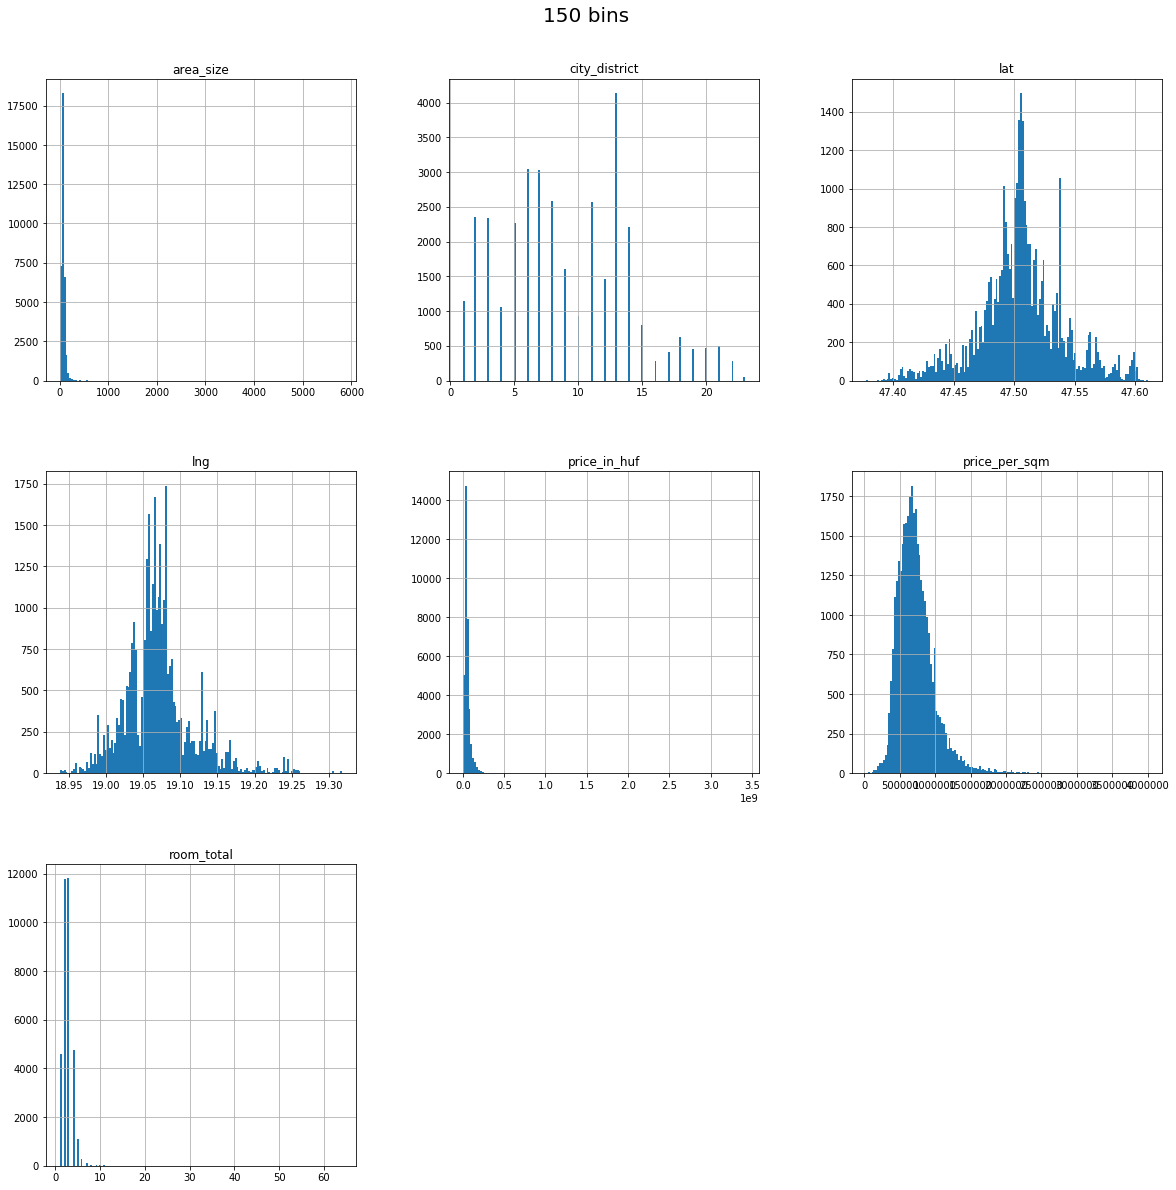

In [28]:
bins=150
train_sale[num_feat].hist(bins=bins, figsize=(20,20))
plt.suptitle('{} bins'.format(bins), fontsize=20, weight=15, y=0.93)
plt.savefig('{0}/{1}_bins_{2}{3}'.format(IMG_DIR, 'histograms', bins, '.png'))

### Data transformation
- Log-Normal Distribution

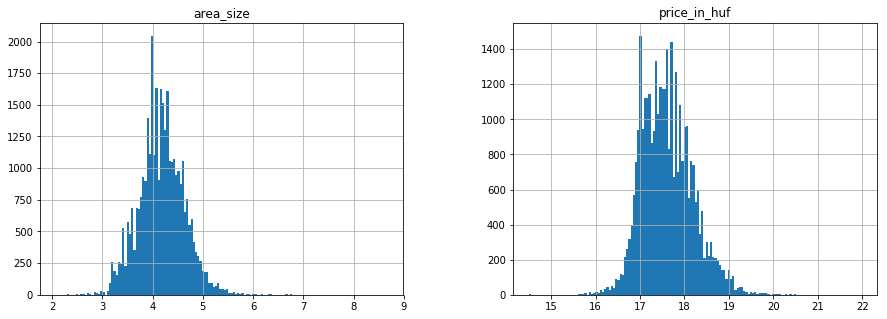

In [29]:
train_sale[['price_in_huf', 'area_size']].apply(np.log).hist(bins=bins, figsize=(15,5))
plt.show()

### Adding transformed columns

In [30]:
train_sale['log_price_in_huf']=train_sale.price_in_huf.apply(np.log)
train_sale['log_area_size']=train_sale.area_size.apply(np.log)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Cross correlation between variables

In [31]:
num_feat=[i for i in train_sale if (train_sale[i].dtype!=object) & (i not in ['id'])]

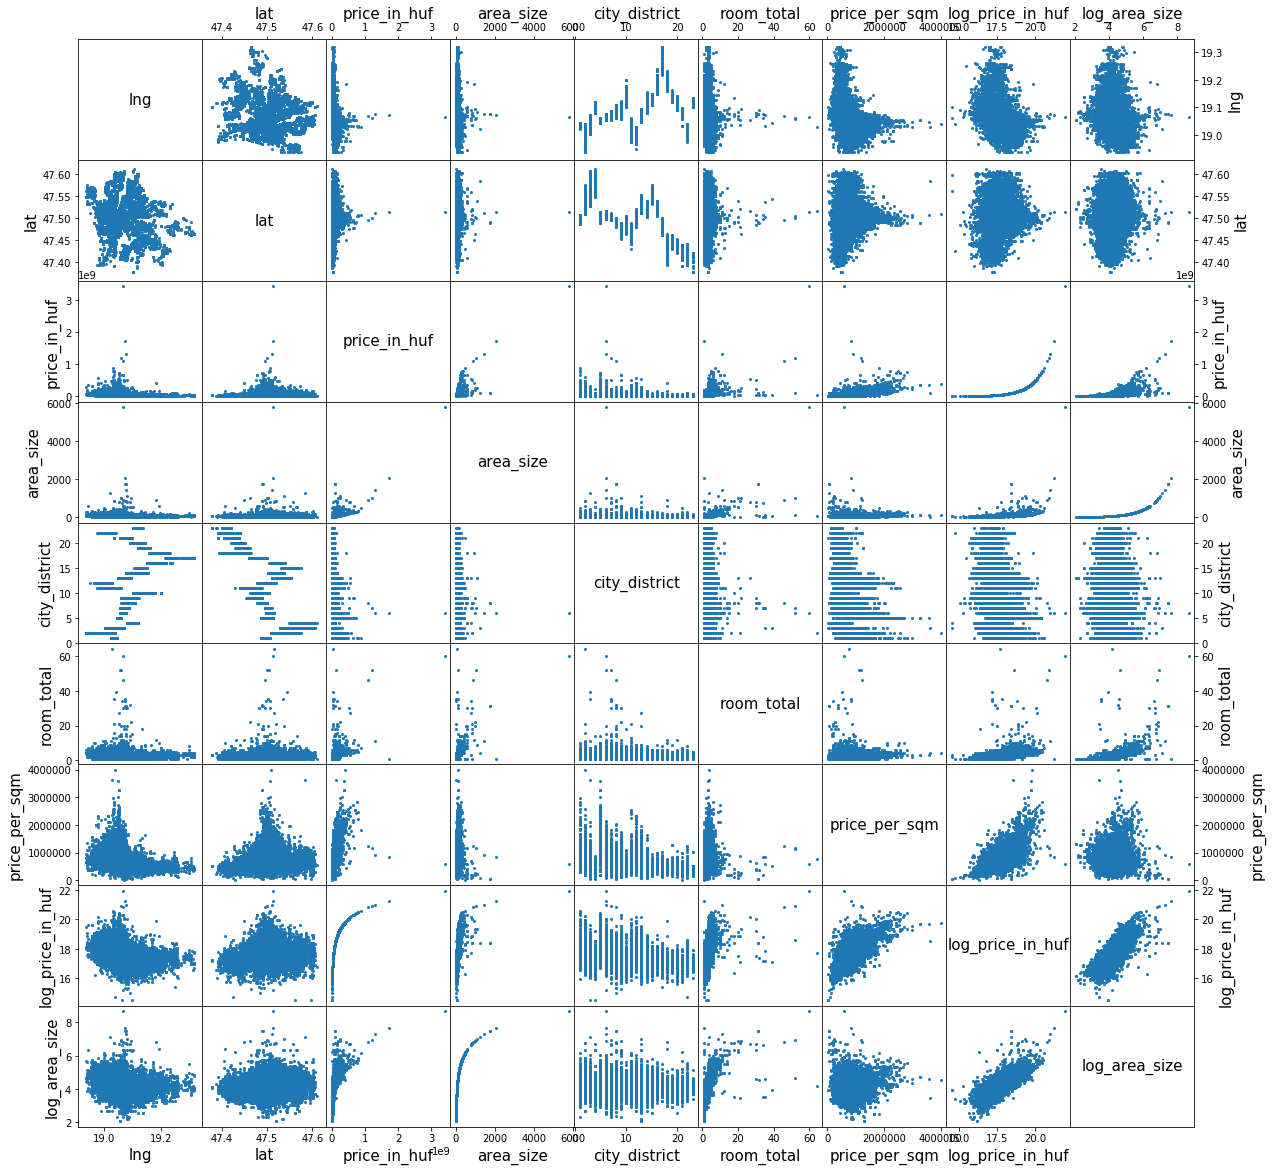

In [32]:
df=train_sale[num_feat].copy()
plot_scatter_matrix(df)

In [33]:
corr=df.corr()
corr.style.background_gradient()

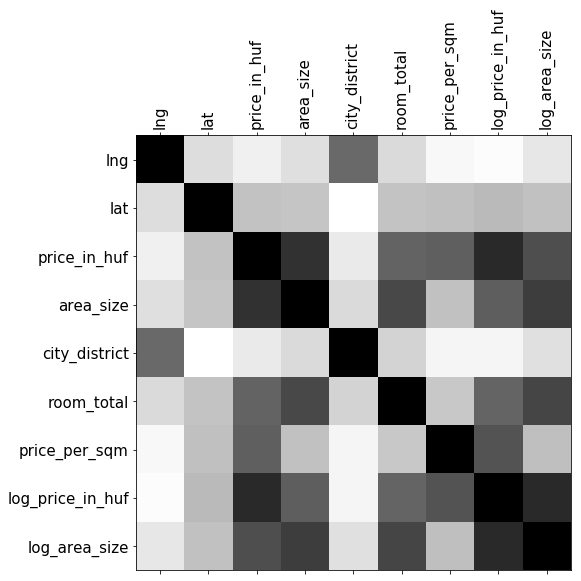

In [34]:
fig=plt.figure(figsize=(8,8))
ax=fig.gca()
ax.matshow(df.corr(), cmap='Greys')
ax.xaxis.set_ticklabels(ticklabels=['']+df.corr().columns.tolist(), rotation=90, fontsize=15)
ax.yaxis.set_ticklabels(ticklabels=['']+df.corr().columns.tolist(), fontsize=15)
plt.show()

### Longitude, Latitude - Scale: Interval

- Measurement scales
    - Nominal, category
    - Ordinal
    - Interval
    - Ratio

In [35]:
min_gps=train_sale[['lng', 'lat']].min()
max_gps=train_sale[['lng', 'lat']].max()
pic_ratio=(max_gps['lat']-min_gps['lat'])/(max_gps['lng']-min_gps['lng'])
print(pic_ratio)

0.6149237587717099


In [36]:
opt_fig_size=calc_fig_size(pic_ratio, 2.5)

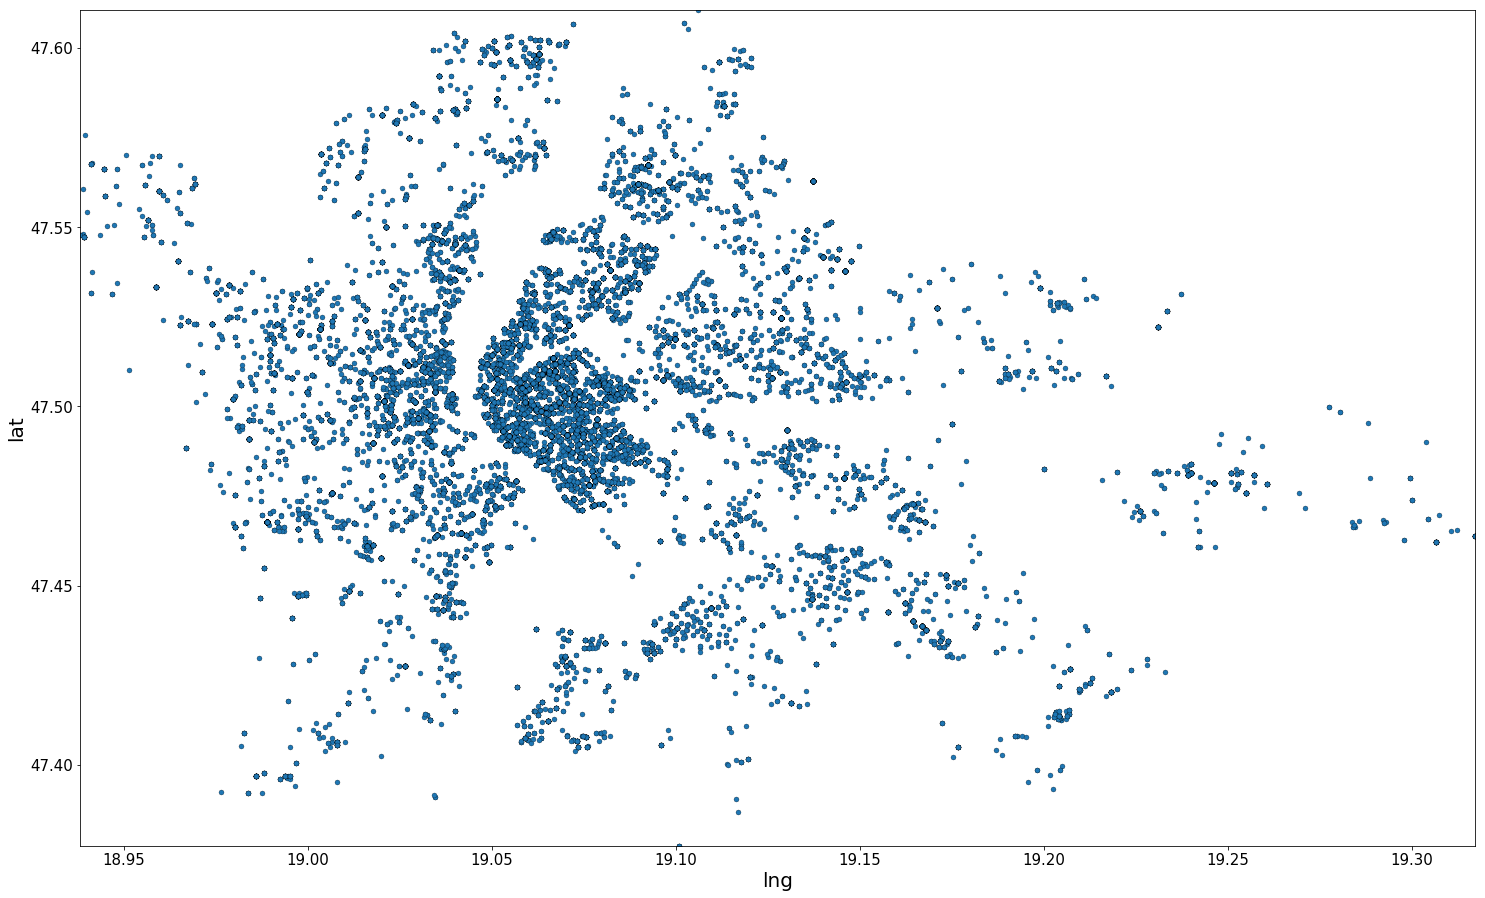

In [37]:
ax=plt.gca()
train_sale[['lng', 'lat']].plot(kind='scatter', x='lng', y='lat', ax=ax, s=25, alpha=1, linewidth=0.25, edgecolor='Black', figsize=opt_fig_size, xlim=(min_gps['lng'], max_gps['lng']), ylim=(min_gps['lat'], max_gps['lat']))
ax.xaxis.set_label_text('lng', fontdict={'fontsize':20})
ax.axes.tick_params(labelsize=15)
ax.yaxis.set_label_text('lat', fontdict={'fontsize':20})
plt.show()

- Adding map to the scatter plot

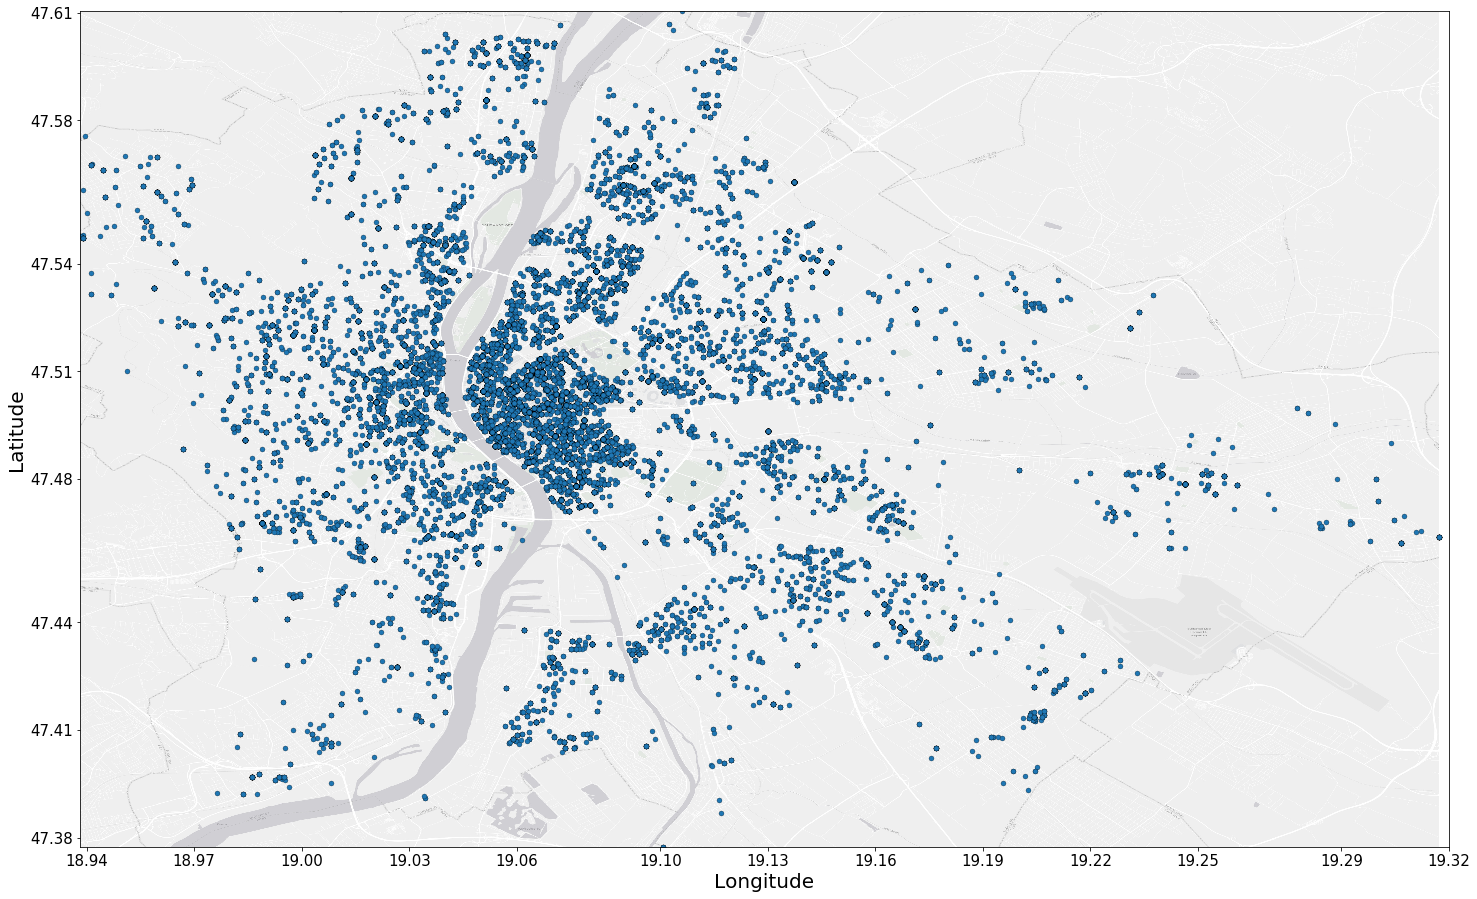

In [38]:
plot_scatter_map(x=train_sale.lng, y=train_sale.lat, xlabel='Longitude', ylabel='Latitude', figsize=opt_fig_size, dpi=160)

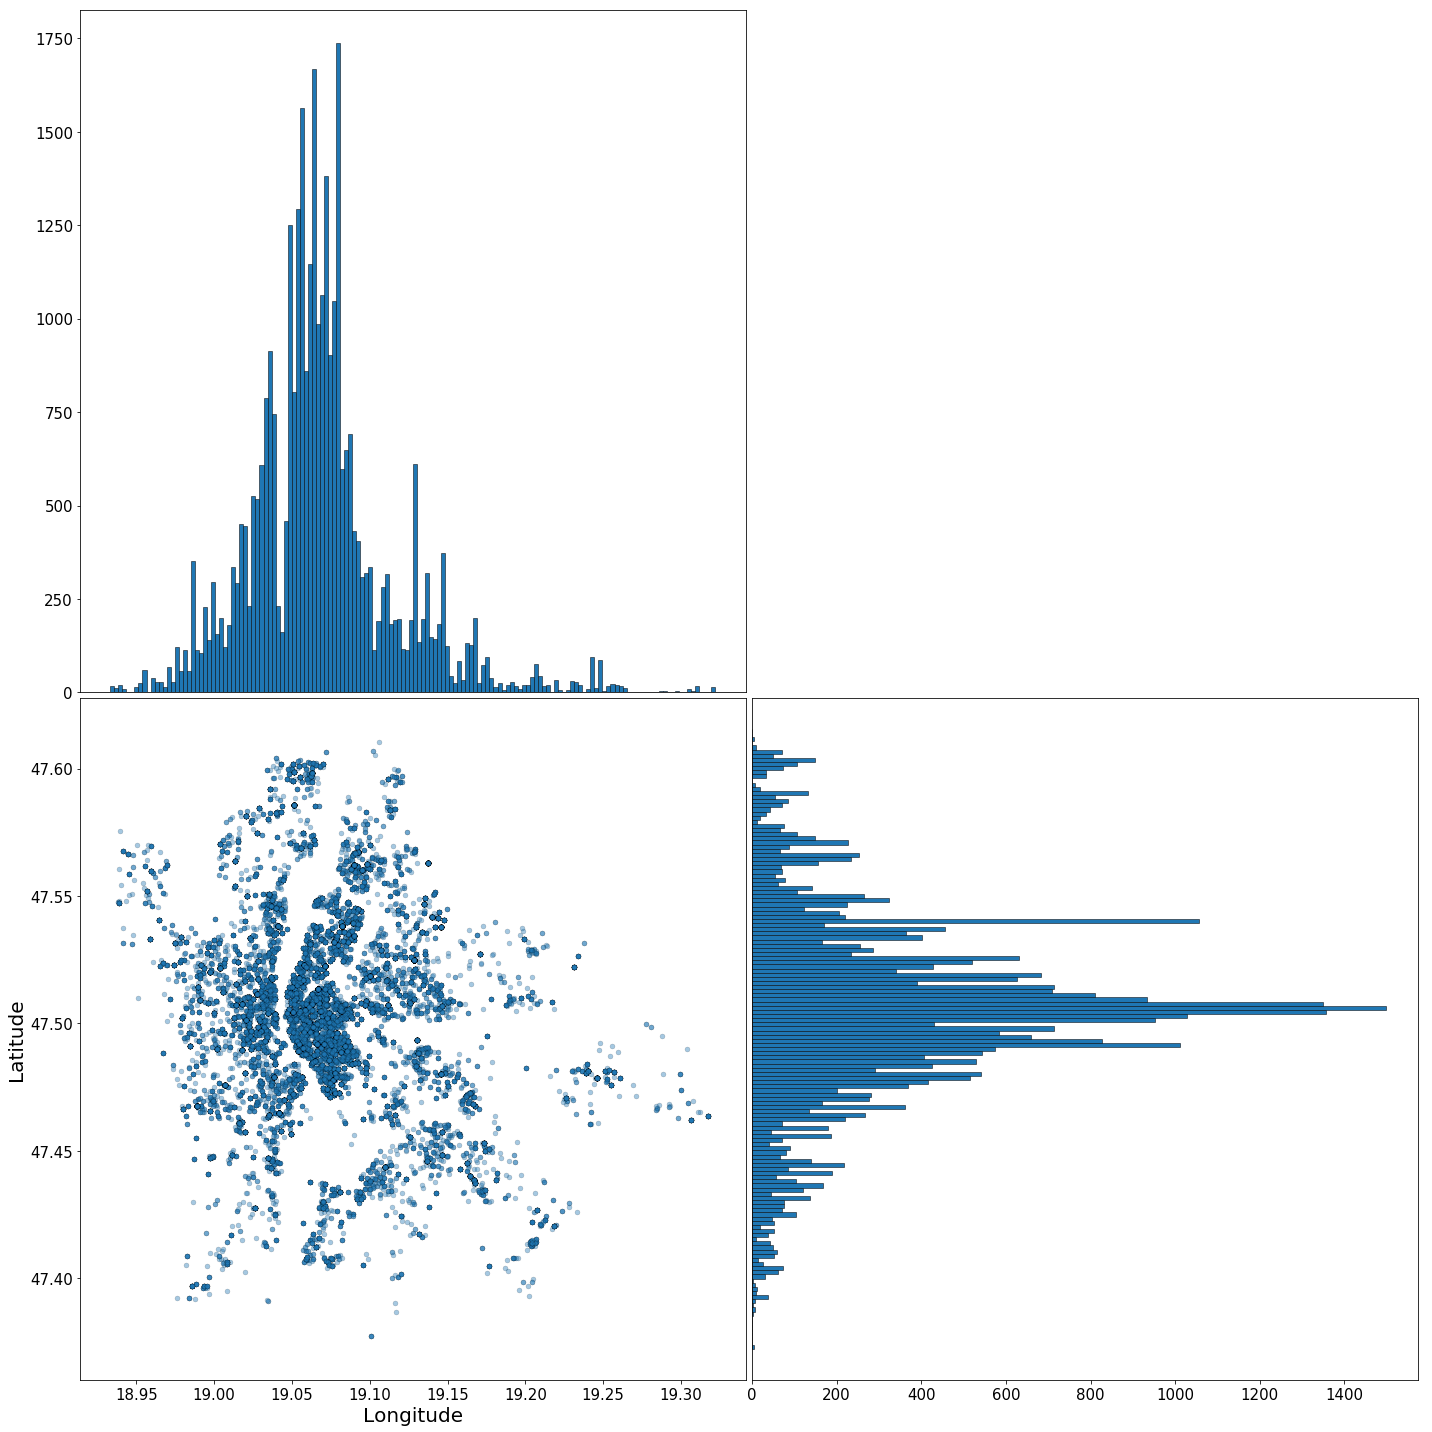

In [39]:
plot_sca_hist(train_sale[['lng', 'lat']], 'lng', 'lat', bins, 'Longitude', 'Latitude')

Data distributed by districts

In [65]:
with open(os.path.join(DATA_DIR, 'colors_23'), 'rb') as f:
    rnd_colors=pickle.load(f)

In [72]:
rnd_colors=np.random.choice(list(mpl.cm.colors.cnames.keys()), size=23, replace=False)

In [73]:
plt.style.use('ggplot')

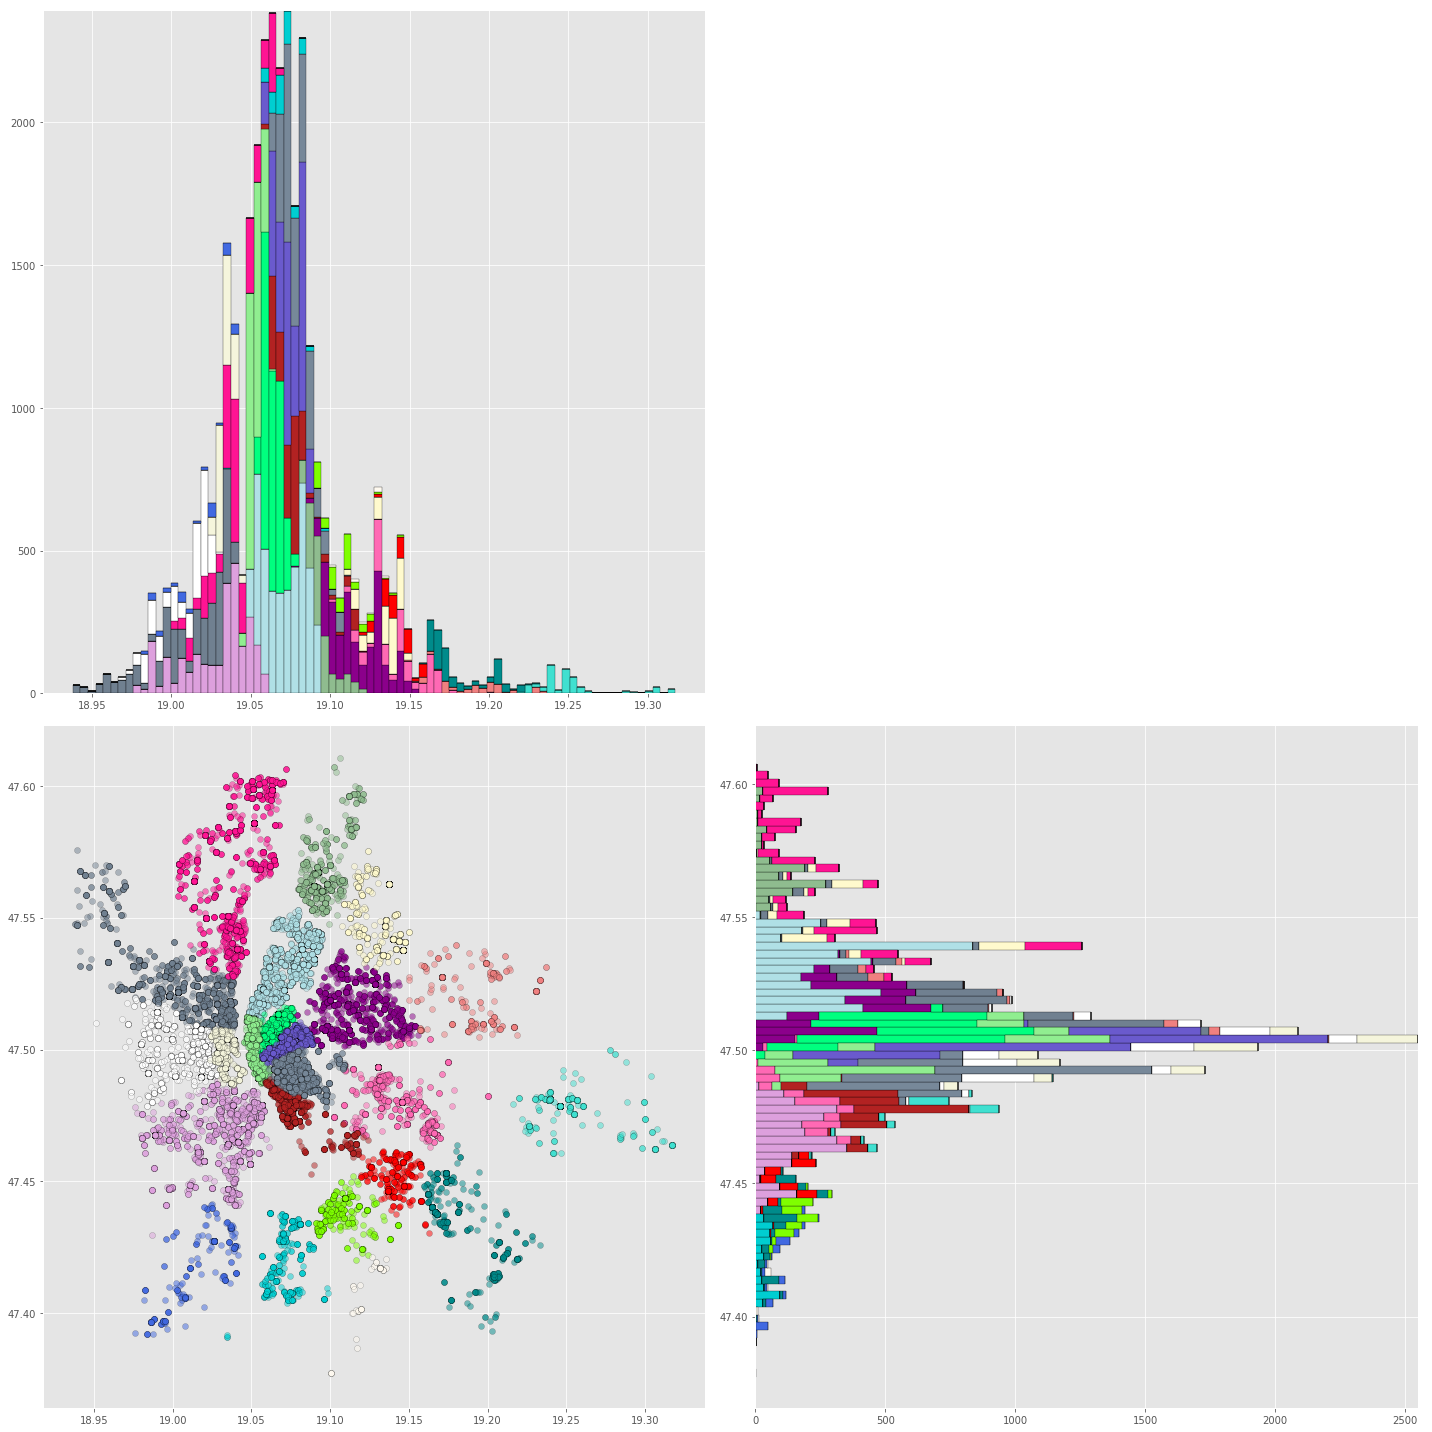

In [75]:
plot_sca_stackedhist(train_sale, 'lng', 'lat', 'city_district', rnd_colors)

Top 10 number of addresses pointing to the same GPS coordinates:

In [40]:
gps_count=train_sale[['lng', 'lat', 'address']].groupby(['lng', 'lat']).count().sort_values('address', ascending=False)
gps_count.head(10)

address
lng       lat               
19.082080 47.538097      512
19.066608 47.513428      329
19.058195 47.505077      282
19.054825 47.491750      268
19.050583 47.504430      259
19.128630 47.524723      258
19.071003 47.522550      206
19.072440 47.501980      196
19.080984 47.505295      186
19.076586 47.477943      171

In [41]:
address_count=train_sale[['lng', 'lat', 'address']].groupby(['address']).count().sort_values(['lng', 'lat'], ascending=False)
address_count.head()

lng  lat
address                   
Angyalföld        558  558
Külső-Terézváros  329  329
Alsórákos         302  302
Belső-Terézváros  282  282
Király utca       272  272

#### GPS Coordinates
The issue with the gps coordinates is that if the user has not specified the exact address only the district then gps coordinates point to the center of the district, consequently longitude and latitude pairs are not accurate enough.  
**Solution**: remove these records, since they include too broad set of properties.<br><br>
Four homogeneity levels have been identified:
    1. Fully specified address (contains street number, street name) e.g. Király utca 13.
    2. Residental park is defined e.g. Greenside
    3. Street name is given e.g. Mester utca
    4. Subdistrict name is provided e.g. Aquincum

- Fully specified address

In [42]:
public_domains=get_public_domain_names()

In [43]:
public_domains=load_public_domain_names(os.path.join(DATA_DIR, 'public_domains_2015_09_07.txt'))

In [44]:
street_num_ptrn='|'.join(['.*{}.*\d'.format(d) for d in public_domains])
street_num_mask=train_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=street_num_ptrn)))
street_num_mask.sum()

2084

In [45]:
train_sale[street_num_mask].tail()

id        lng        lat  price_in_huf  area_size  \
55006  1.562761e+09  19.062881  47.495396    64940000.0       72.0   
55063  1.562420e+09  19.075905  47.488605    45500000.0      124.0   
55079  1.562071e+09  19.204250  47.414990    50000000.0       91.0   
55082  1.562030e+09  19.136728  47.490860     8000000.0       54.0   
55086  1.561964e+09  18.992636  47.479630    40500000.0       58.0   

       city_district                     address listing_type  \
55006              7              Dohány utca 9.     for-sale   
55063              8          Hock János utca 3.     for-sale   
55079             18             Fenyőfa utca 1.     for-sale   
55082             10  Kőrösi Csoma Sándor út 40.     for-sale   
55086             11         Törökbálinti út 24.     for-sale   

      residental_park_name  room_total  price_per_sqm  log_price_in_huf  \
55006                  NaN         3.0  901944.444444         17.988974   
55063                  NaN         4.0  366935.483871         17.633223   
55079                  NaN         3.0  549450.549451         17.727534   
55082                  NaN         2.0  148148.148148         15.894952   
55086                  NaN         3.0  698275.862069         17.516813   

       log_area_size  
55006       4.276666  
55063       4.820282  
55079       4.510860  
55082       3.988984  
55086       4.060443

- Residental park

In [46]:
residental_park_mask=train_sale.loc[:,'residental_park_name'].notnull()
residental_park_mask.sum()

1096

- Street name

In [47]:
pub_domain_ptrn='|'.join(['.* {}$'.format(d) for d in public_domains])
public_domains_mask=train_sale.address.apply(lambda a: bool(re.match(string=str(a), pattern=pub_domain_ptrn)))
public_domains_mask.sum()

21308

In [48]:
train_sale[public_domains_mask].tail()

id        lng        lat  price_in_huf  area_size  \
55134  1.547647e+09  19.023384  47.517258   220000000.0      194.0   
55135  1.547506e+09  19.032919  47.525936   152000000.0      295.0   
55136  1.547478e+09  19.062782  47.511730    47900000.0       84.0   
55137  1.547459e+09  19.052720  47.501560   179000000.0      109.0   
55140  1.546887e+09  19.050991  47.496605   550000000.0      280.0   

       city_district            address listing_type residental_park_name  \
55134              2           Bimbó út     for-sale                  NaN   
55135              2     Felhévízi utca     for-sale                  NaN   
55136              6   Podmaniczky utca     for-sale                  NaN   
55137              5  Hercegprímás utca     for-sale                  NaN   
55140              5     Vörösmarty tér     for-sale                  NaN   

       room_total  price_per_sqm  log_price_in_huf  log_area_size  
55134         5.0   1.134021e+06         19.209138       5.267858  
55135         6.0   5.152542e+05         18.839391       5.686975  
55136         2.0   5.702381e+05         17.684626       4.430817  
55137         3.0   1.642202e+06         19.002896       4.691348  
55140         5.0   1.964286e+06         20.125429       5.634790

In [49]:
train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'address'].count()

24392

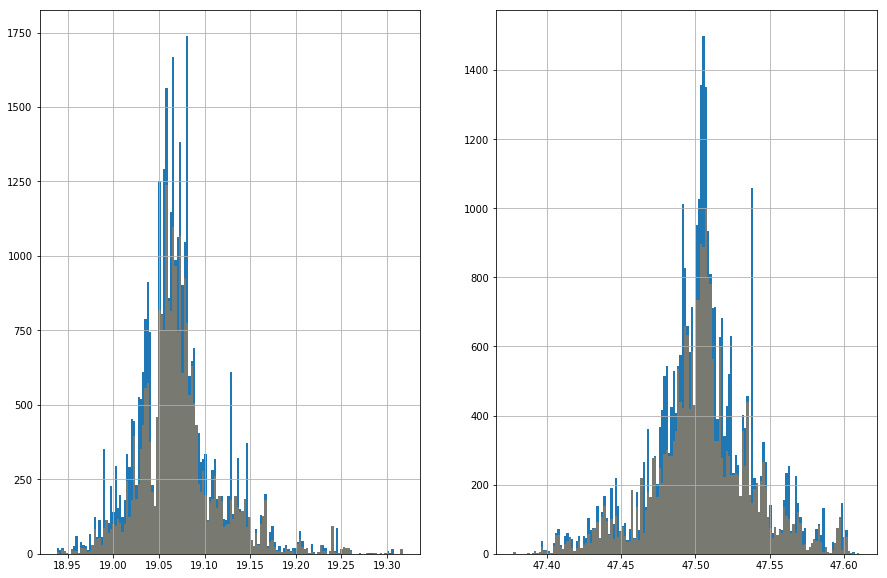

In [50]:
bins=150
fig, axs = plt.subplots(1,2)
fig.set_size_inches(30,20)
train_sale.loc[:, 'lng'].hist(bins=bins, ax=axs[0])
train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'lng'].hist(figsize=(15,10), bins=bins, ax=axs[0], alpha=0.4)
train_sale.loc[:, 'lat'].hist(bins=bins, ax=axs[1])
train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'lat'].hist(figsize=(15,10), bins=bins, ax=axs[1], alpha=0.4)

In [51]:
normaltest(train_sale.loc[street_num_mask|residental_park_mask|public_domains_mask, 'price_per_sqm'])

NormaltestResult(statistic=9735.969478637397, pvalue=0.0)

### Exporting subdisctrict names with corresponding gps coordianates

In [52]:
sub_district_map=train_sale.loc[~street_num_mask&~residental_park_mask&~public_domains_mask, ['lng', 'lat', 'address']].dropna().drop_duplicates()
ptrn='|'.join(['.* {} [0-9A-Z]$'.format(d) for d in public_domains])
sub_district_map=sub_district_map[~sub_district_map.address.apply(lambda a: bool(re.match(string=str(a), pattern=ptrn)))]
sd_path=os.path.join(DATA_DIR,'subdistrict_map.csv')
if not os.path.exists(sd_path):
    sub_district_map.to_csv(sd_path, encoding='utf8', index=False)

### Removing outliers
- Standardization:
    - Subtracting mean (centered)
    - Dividing by standard deviation (scaled)

In [53]:
df=train_sale.loc[:, num_feat].copy()

In [54]:
scaler=StandardScaler()

In [55]:
st_arr=scaler.fit_transform(df)

In [56]:
st_df=pd.DataFrame(st_arr, columns=df.columns)

In [57]:
plot_outliers(st_df, n_std=3)

### Decide the n sigma from mean

In [58]:
ratios=[]
for sigma in np.arange(10, 1, -0.25):
    price_per_sqm_mask=(st_df.price_per_sqm.values<=sigma)&(st_df.price_per_sqm.values>=sigma*(-1))
    log_price_mask=(st_df.log_price_in_huf.values<=sigma)&(st_df.log_price_in_huf.values>=sigma*(-1))
    log_area_mask=(st_df.log_area_size.values<=sigma)&(st_df.log_area_size.values>=sigma*(-1))
    lng_mask=(st_df.lng.values<=sigma)&(st_df.lng.values>=sigma*(-1))
    lat_mask=(st_df.lat.values<=sigma)&(st_df.lat.values>=sigma*(-1))
    total_records=len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask),num_feat])
    filtered_records=len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&price_per_sqm_mask&log_price_mask&log_area_mask&lng_mask&lat_mask, num_feat])
    ratio=1-(filtered_records/total_records)
    ratios.append(ratio*100)

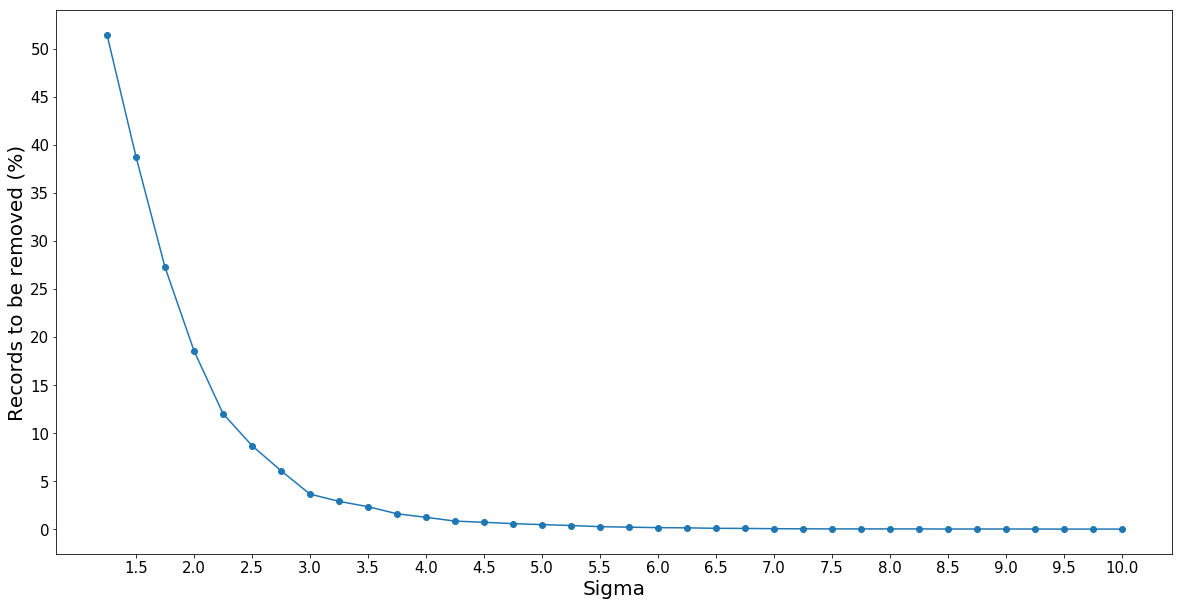

In [59]:
fig=plt.figure(figsize=(20,10))
plt.plot(np.arange(10, 1, -0.25), ratios, marker='o')
plt.xticks(np.arange(10, 1, -0.5), fontsize=15)
plt.yticks(np.arange(50, -1, -5), fontsize=15)
plt.xlabel('Sigma', fontsize=20)
plt.ylabel('Records to be removed (%)', fontsize=20)
plt.show()

### Sigma input

In [60]:
sigma=2.5

In [61]:
price_per_sqm_mask=(st_df.price_per_sqm.values<=sigma)&(st_df.price_per_sqm.values>=sigma*(-1))
log_price_mask=(st_df.log_price_in_huf.values<=sigma)&(st_df.log_price_in_huf.values>=sigma*(-1))
log_area_mask=(st_df.log_area_size.values<=sigma)&(st_df.log_area_size.values>=sigma*(-1))
lng_mask=(st_df.lng.values<=sigma)&(st_df.lng.values>=sigma*(-1))
lat_mask=(st_df.lat.values<=sigma)&(st_df.lat.values>=sigma*(-1))
total_records=len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask),num_feat])
filtered_records=len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&price_per_sqm_mask&log_price_mask&log_area_mask&lng_mask&lat_mask, num_feat])
ratio=filtered_records/total_records

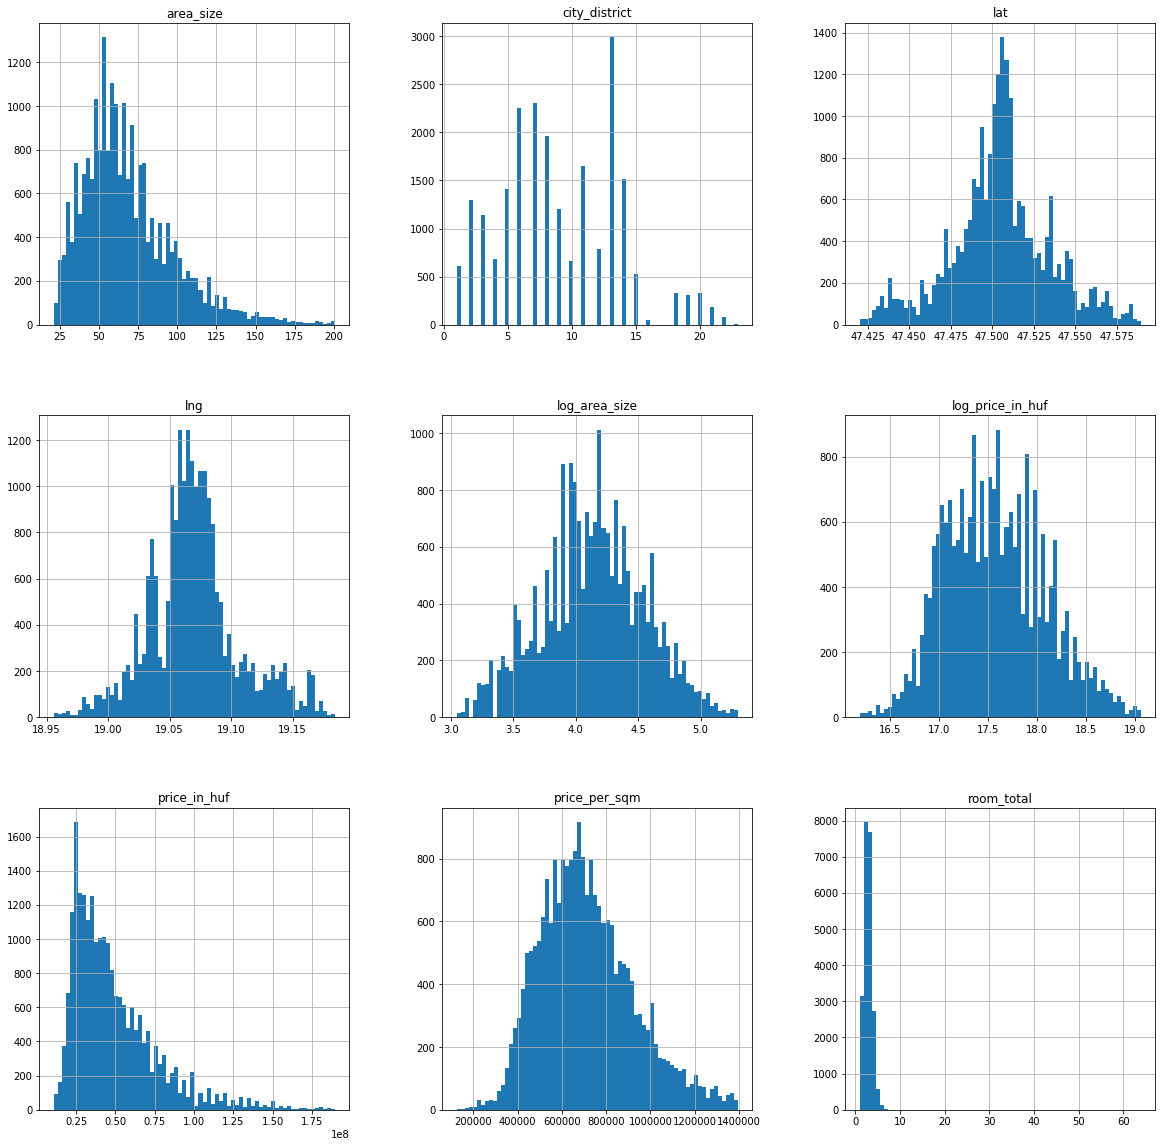

In [62]:
train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&price_per_sqm_mask&log_price_mask&log_area_mask&lng_mask&lat_mask, num_feat].hist(bins=70, figsize=(20,20))
plt.show()

In [63]:
len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)&log_price_mask&log_area_mask, num_feat])/len(train_sale.loc[(street_num_mask|residental_park_mask|public_domains_mask)])

0.9766726795670712

### Eyeballing the heat map

In [64]:
all_mask=(street_num_mask|residental_park_mask|public_domains_mask)&log_price_mask&log_area_mask
plot_scatter_map(x=train_sale.loc[all_mask, 'lng'],
                 y=train_sale.loc[all_mask, 'lat'],
                 c=train_sale.loc[all_mask, 'price_per_sqm'],
                 colormap='hot', c_bar_shrink=0.81,
                 xlabel='Longitude', ylabel='Latitude', clabel='Price per Squaremeter',
                 linewidth=0, s=50, alpha=0.7,
                 figsize=opt_fig_size, dpi=160)

### Classification
- Train a model, which can distinguish between Budapest and Danube
    1. Get the coordinates of Danube

In [77]:
danube=load_danube_gps_coordinates(json_path=os.path.join(DATA_DIR, 'danube.geojson'))

In [76]:
min_gps=train_sale.loc[all_mask].min()
max_gps=train_sale.loc[all_mask].max()

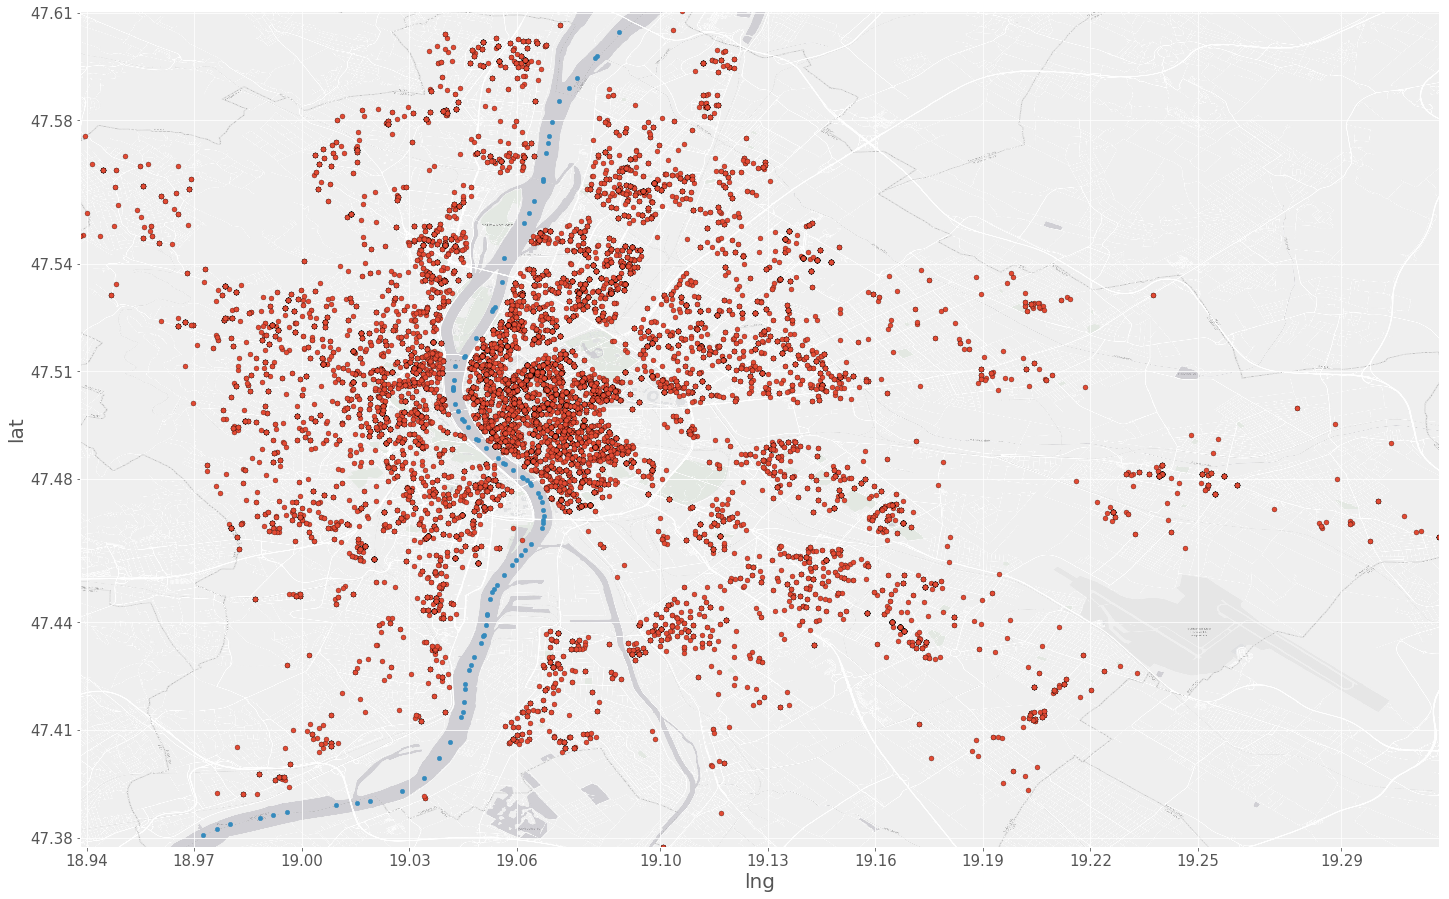

In [95]:
fig, ax = plot_scatter_map(x=train_sale.loc[all_mask,'lng'], y=train_sale.loc[all_mask,'lat'], xlabel='Longitude', ylabel='Latitude', figsize=opt_fig_size, dpi=160)
danube.plot(kind='scatter', x='lng', y='lat', ax=ax, xlim=(min_gps['lng'], max_gps['lng']), ylim=(min_gps['lat'], max_gps['lat']))

---

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot()

In [ ]:
data=train_sale.loc[(train_sale.lng==top_10.iloc[0].name[0])&(train_sale.lat==top_10.iloc[0].name[1]), ['price_in_huf', 'area_size', 'room_lt_12_sqm', 'room_ge_12_sqm']]
scatter_matrix(data, figsize=(20,20), hist_kwds={'bins':30})
plt.show()

In [ ]:
import mpld3

In [ ]:
import plotly
plotly.offline.init_notebook_mode()

In [ ]:
plt.scatter(x=raw.loc[raw.listing_type=='for-sale' ,'lng'].values,
            y=raw.loc[raw.listing_type=='for-sale' ,'lat'].values, alpha=1, s=25, marker='o', color='b')
# fig=plt.gcf()
# mpld3.display(fig)
pfig = plotly.tools.mpl_to_plotly(plt.gcf())
plotly.offline.iplot(pfig)

In [ ]:
plt.scatter(x=danube.lng.values, y=danube.lat.values)